# HierarQcal Quickstart
The idea of this notebook is to quickly showcase different kinds of circuits that can be built with the package. More in depth tutorials are given in other notebooks, this only to functions as a quick view of some functionality.


### Overview
<img src="https://github.com/matt-lourens/hierarqcal/blob/master/img/dalle_img.png?raw=true" width="300" align="left" style="padding-right:10px">

<p style="height:150px">
<b>HierarQcal</b> is a quantum circuit builder that simplifies circuit design, composition, generation, scaling, and parameter management. It provides an intuitive and dynamic data structure for constructing computation graphs hierarchically. This enables the generation of complex quantum circuit architectures, which is particularly useful for Neural Architecture Search (NAS), where an algorithm can determine the most efficient circuit architecture for a specific task and hardware. HierarQcal also facilitates the creation of hierarchical quantum circuits, such as those resembling tensor tree networks or MERA, with a single line of code. The package is open-source and framework-agnostic, it includes tutorials for Qiskit, PennyLane, and Cirq. Built to address the unique challenges of applying NAS to Quantum Computing, HierarQcal offers a novel approach to explore and optimize quantum circuit architectures. 
</p>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>


*A robot building itself with artificial intelligence, pencil drawing -  generated with* [Dall E 2](https://openai.com/dall-e-2/)

In [188]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from hierarqcal import (
    Qhierarchy,
    Qcycle,
    Qpermute,
    Qmask,
    Qunmask,
    Qpivot,
    Qinit,
    Qmotif,
    Qmotifs,
    plot_motif,
    plot_circuit,
    Qunitary,
)

In [189]:
backend = "qiskit"

In [190]:
if backend == "qiskit":
    import qiskit
    from hierarqcal.qiskit.qiskit_circuits import V2, U2, V4

    def get_circuit(hierq):
        return hierq(backend="qiskit")

    def draw_circuit(circuit, **kwargs):
        return circuit.draw(output="mpl", **kwargs)

elif backend == "cirq":
    import cirq
    from cirq.contrib.svg import SVGCircuit
    from hierarqcal.cirq.cirq_circuits import V2, U2, V4
    import logging
    logging.getLogger('matplotlib.font_manager').disabled = True
    def get_circuit(hierq):
        return hierq(backend="cirq")

    def draw_circuit(circuit, **kwargs):
        return SVGCircuit(circuit, **kwargs)

elif backend == "pennylane":
    import pennylane as qml
    from hierarqcal.pennylane.pennylane_circuits import V2, U2, V4

    def get_circuit(hierq):
        dev = qml.device("default.qubit", wires=hierq.tail.Q)

        @qml.qnode(dev)
        def circuit():
            if isinstance(next(hierq.get_symbols(), False), sp.Symbol):
                # Pennylane doesn't support symbolic parameters, so if no symbols were set (i.e. they are still symbolic), we initialize them randomly
                hierq.set_symbols(np.random.uniform(0, 2 * np.pi, hierq.n_symbols))
            hierq(
                backend="pennylane"
            )  # This executes the compute graph in order
            return [qml.expval(qml.PauliZ(wire)) for wire in hierq.tail.Q]

        return circuit

    def draw_circuit(circuit, **kwargs):
        fig, ax = qml.draw_mpl(circuit)(**kwargs)
u2 = Qunitary(U2, 1, 2)
v2 = Qunitary(V2, 0, 2)
v4 = Qunitary(V4, 0, 4)

## Binary trees

Here are some quick examples of combining cycles with masking patterns that forms binary trees. `Qmask` takes a `global_pattern` argument which is a bitstring where `1` specifies mask (ignore) and `0` specifies don't mask. Wildcard characters `!` and `*` can be used where `!` fills with ones and `*` with zeros.

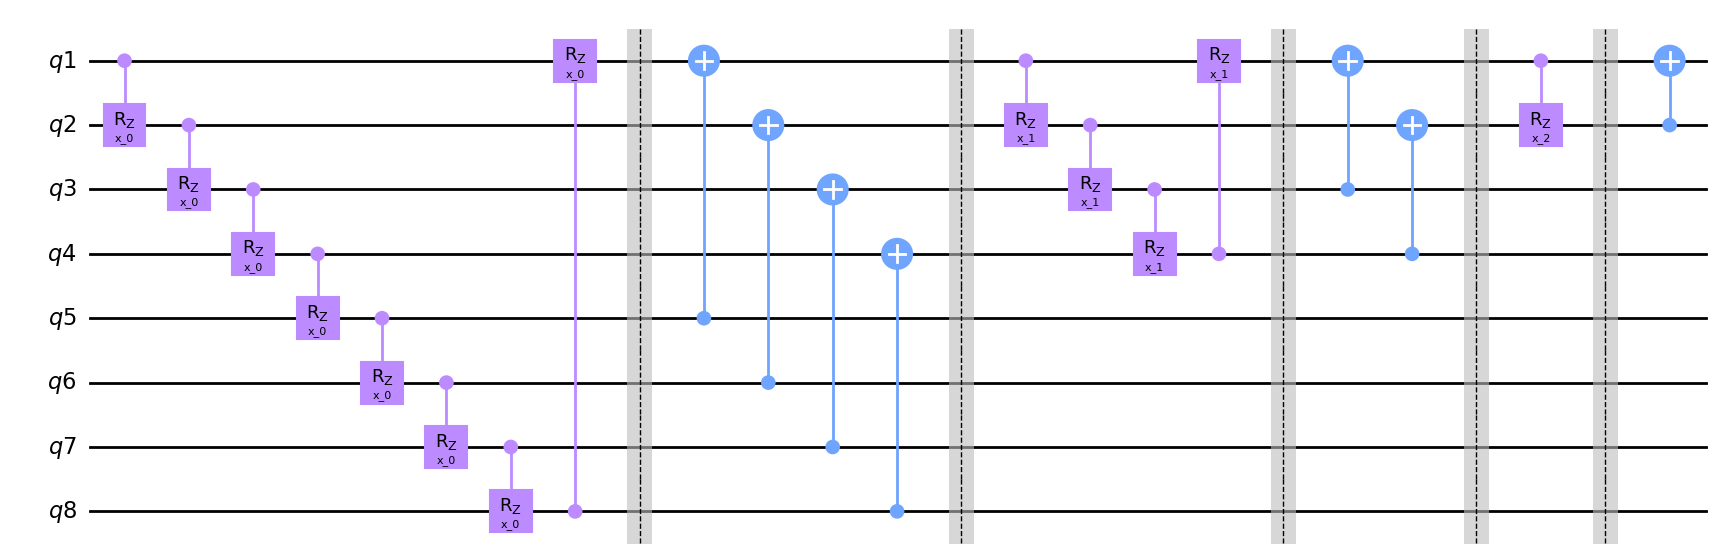

In [191]:
nq = 3
hierq = Qinit(2**nq) + (Qcycle(mapping=u2) + Qmask("*!", mapping=v2))*nq
circuit = get_circuit(hierq)
draw_circuit(circuit)

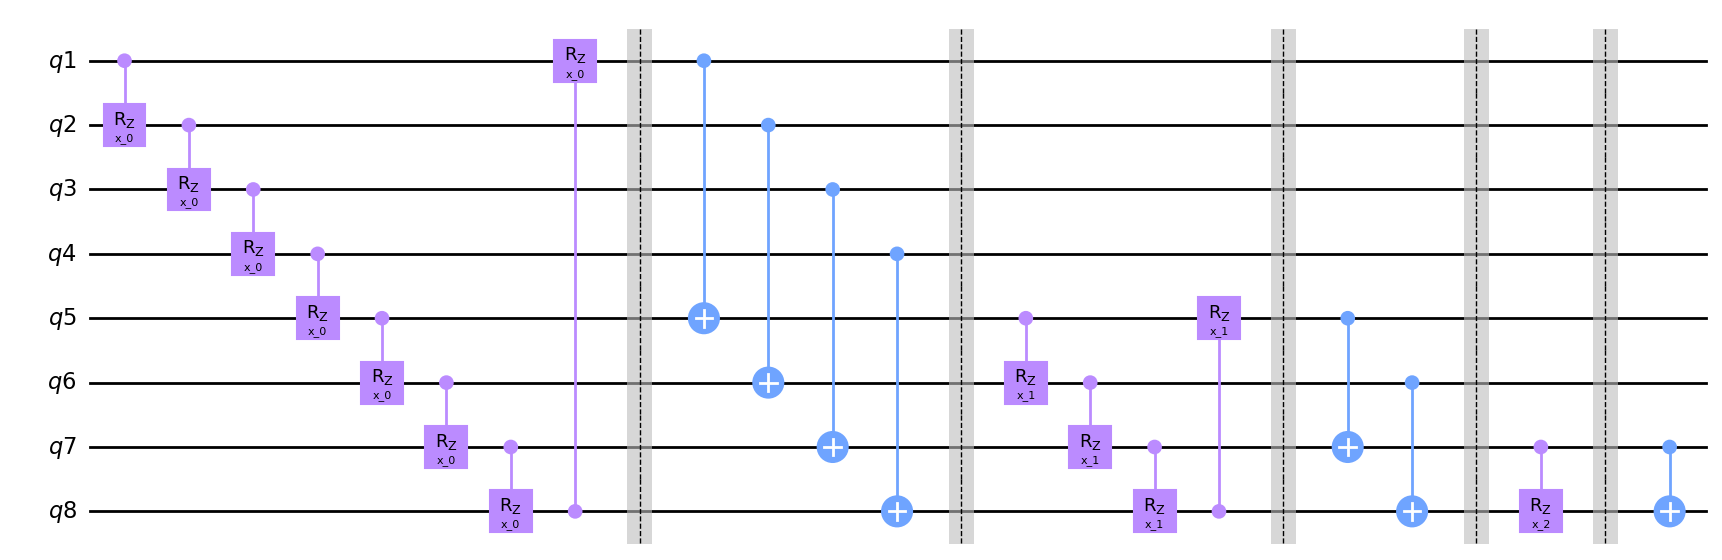

In [192]:
nq = 3
hierq = Qinit(2**nq) + (Qcycle(mapping=u2) + Qmask("!*", mapping=v2))*nq
circuit = get_circuit(hierq)
draw_circuit(circuit)

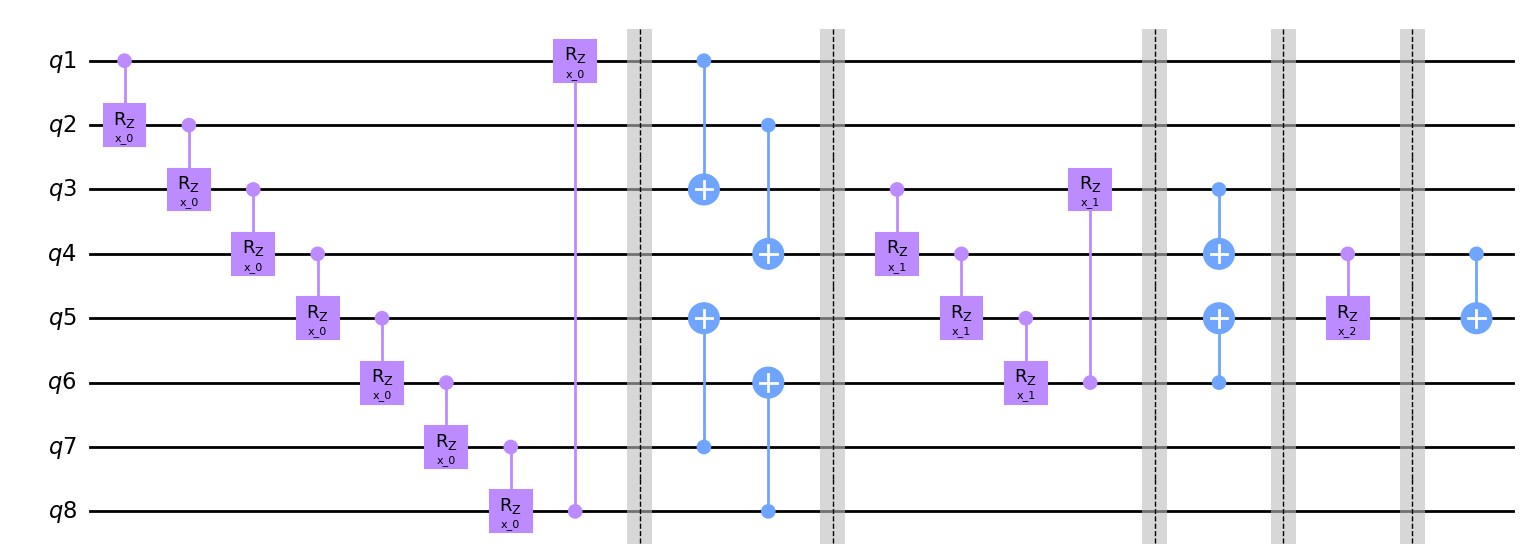

In [193]:
nq = 3
hierq = Qinit(2**nq) + (Qcycle(mapping=u2) + Qmask("!*!", mapping=v2))*nq
circuit = get_circuit(hierq)
draw_circuit(circuit)

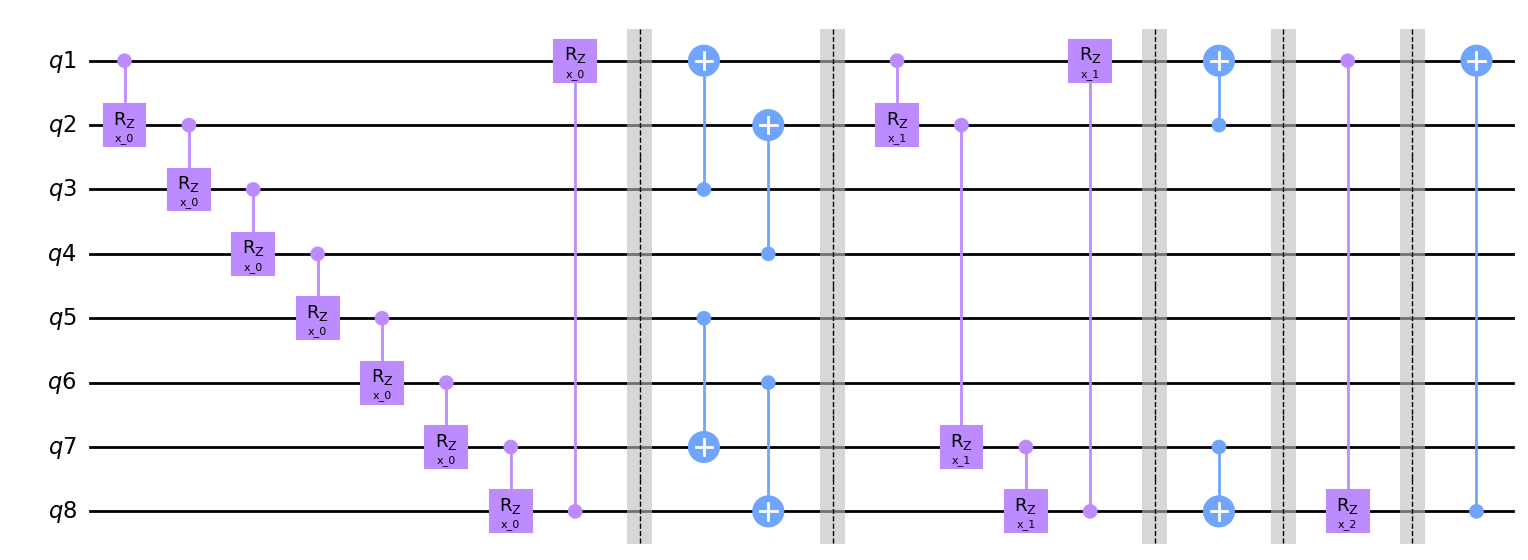

In [194]:
nq = 3
hierq = Qinit(2**nq) + (Qcycle(mapping=u2) + Qmask("*!*", mapping=v2))*nq
circuit = get_circuit(hierq)
draw_circuit(circuit)

## MERA from Grant et al.
The Multi-scale Entanglement Renormalization Ansatz (MERA) architecture from [Hierarchical quantum classifiers, Grant et al.](https://www.nature.com/articles/s41534-018-0116-9). We generate a N-qubit MERA circuit, change N to 4,8,16,32 to see how simple scaling the same circuit design is. Note that v4 is a 4-qubit unitary, which illustrates how primitves can handle N-qubit unitaries.

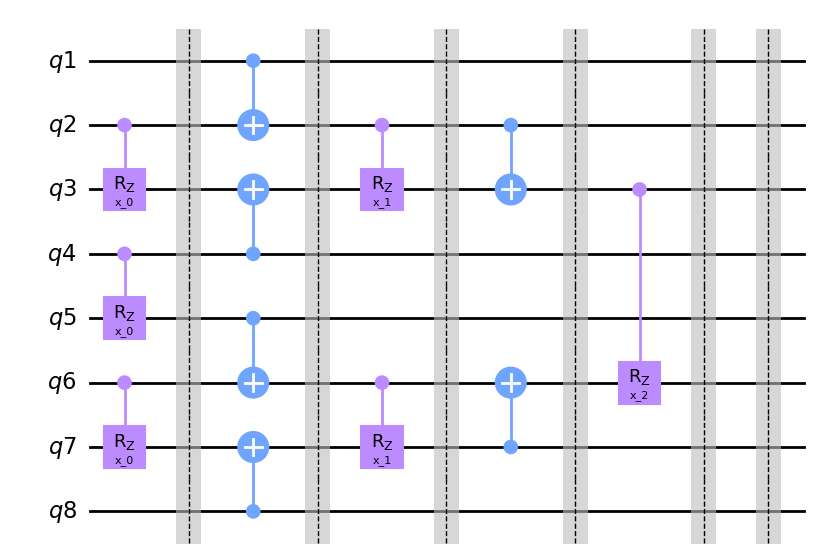

In [195]:
# If you're using qiskit you can create Qunitaries with strings
# u2 = Qunitary("crx(x)^01")
# v4 = Qunitary("cnot()^01;cnot()^32")
N=8
c1 = Qcycle(1,2,1,mapping=u2, boundary="open")
c2 = Qcycle(1,2,0,mapping=u2, boundary="open")
m1 = Qmask("1001", merge_within="1001", steps=[2,2,1], boundaries=["open","open","open"] ,mapping=v4)
hierq = Qinit(N) + c1 + (m1+c2)*int(np.log2(N))
circuit = get_circuit(hierq)
draw_circuit(circuit)

## Sub motif as a mapping for a motif

### A cycle of cycles

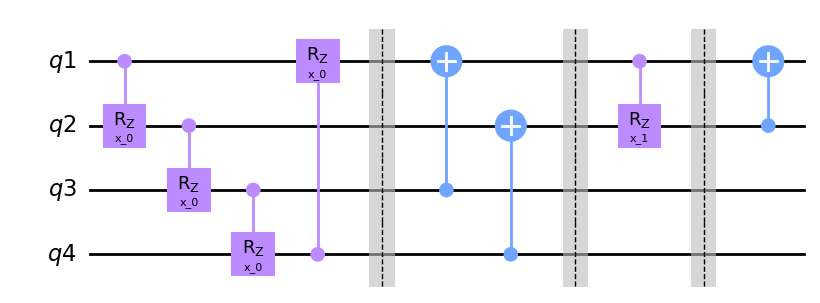

In [196]:
m1 = Qinit(4) + (Qcycle(mapping=u2) + Qmask("right", mapping=v2)) * 2
circuit = get_circuit(m1)
draw_circuit(circuit)

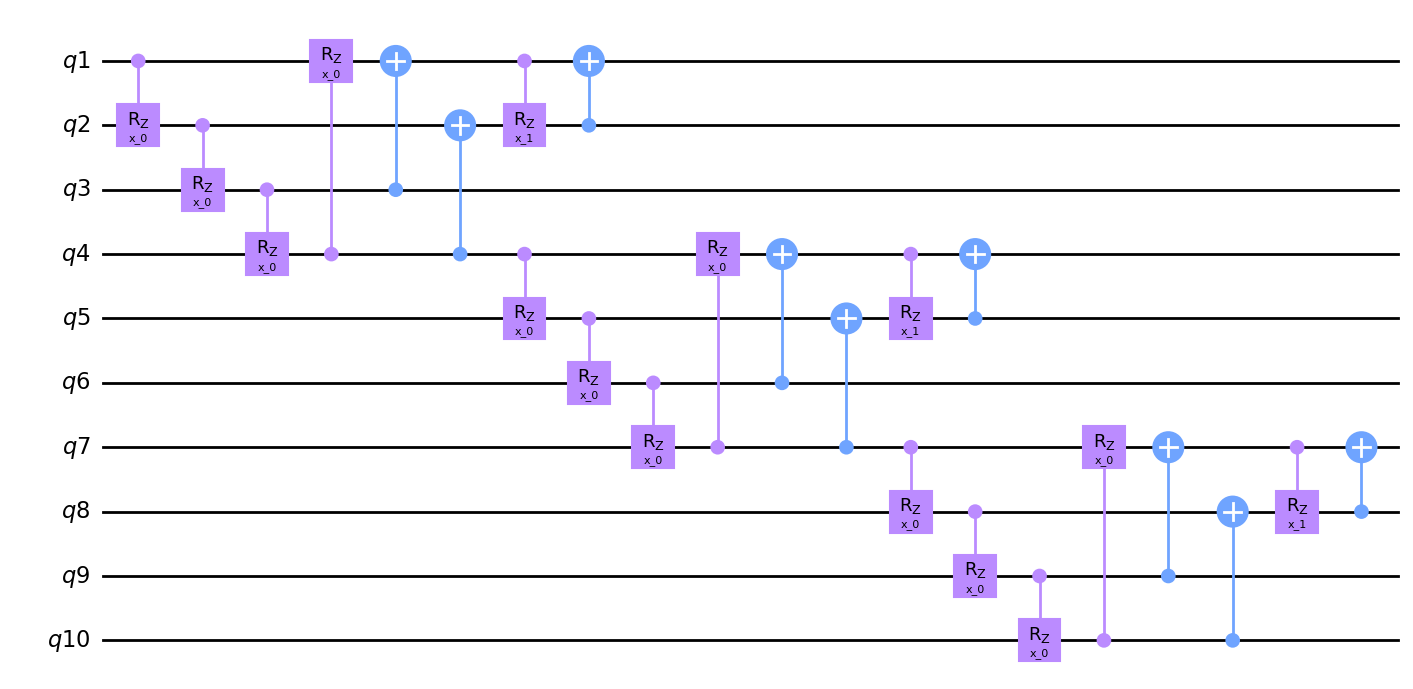

In [197]:
hierq = Qinit(10) + Qcycle(1, 3, mapping=m1, boundary="open")
circuit = get_circuit(hierq)
draw_circuit(circuit)

### A cycle of cycles of permutations

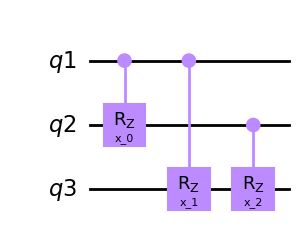

In [198]:
subsub = Qinit(3) + Qpermute(mapping=u2, share_weights=False, combinations=True)
circuit = get_circuit(subsub)
draw_circuit(circuit)

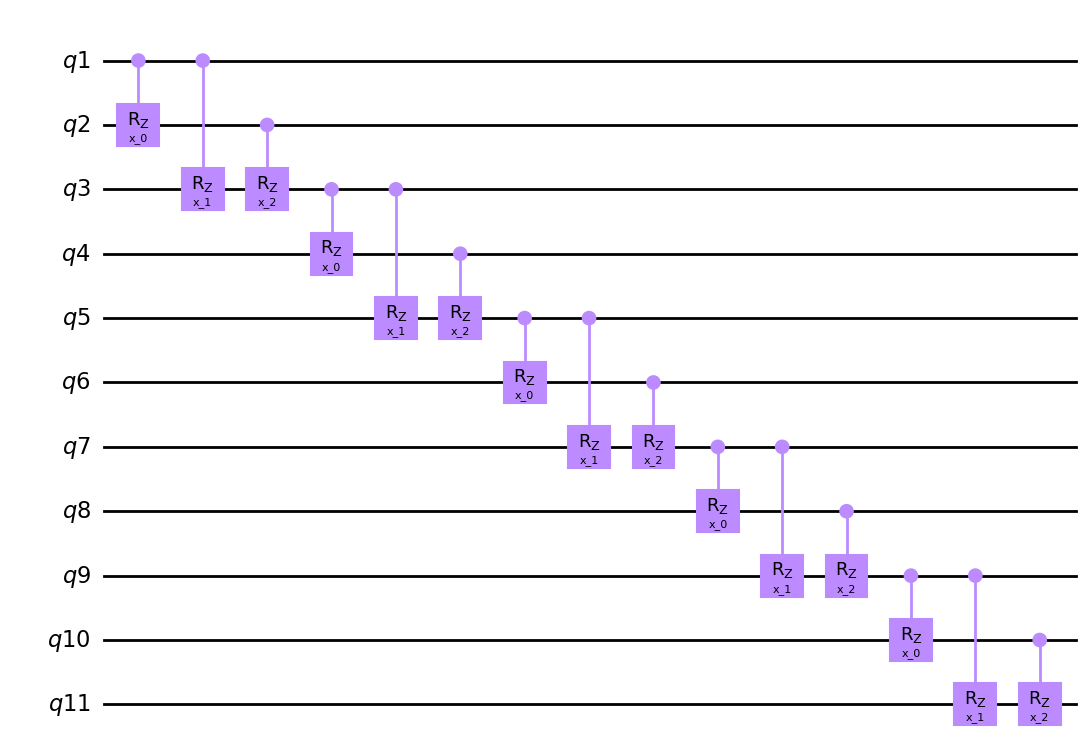

In [199]:
sub = Qinit(11) + Qcycle(
    1, 2, 0, mapping=subsub, share_weights=True, boundary="open"
)
circuit = get_circuit(sub)
draw_circuit(circuit)

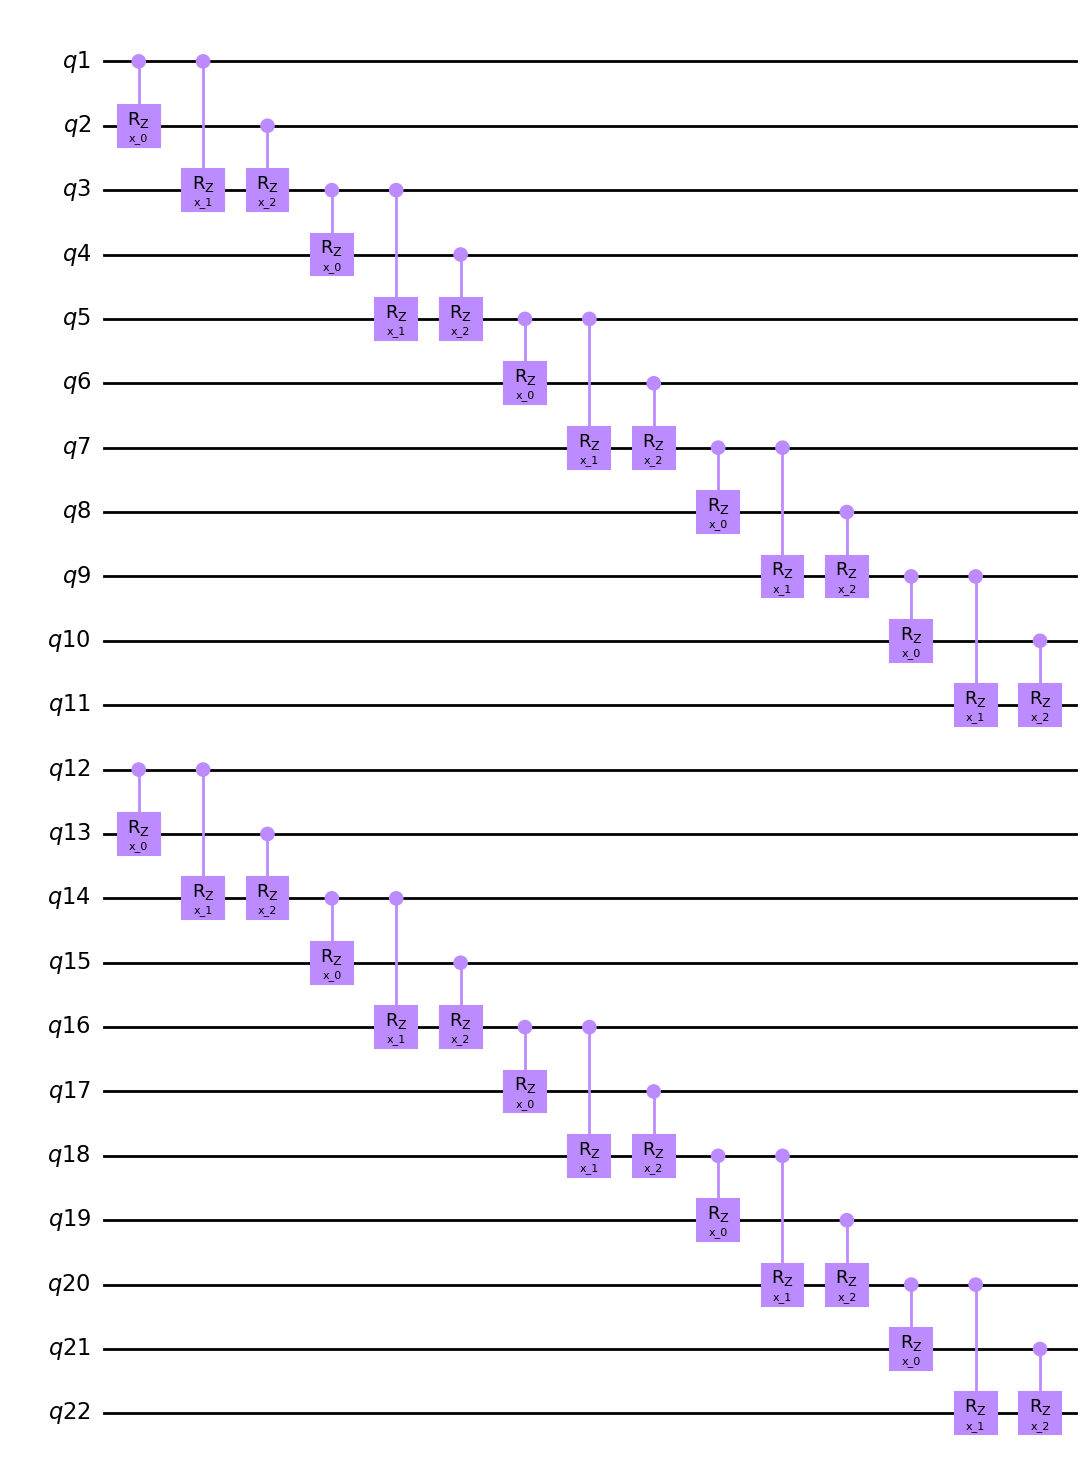

In [200]:
hierq = Qinit(22) + Qcycle(1, 11, 0, mapping=sub, share_weights=False, boundary="open")
circuit = get_circuit(hierq)
draw_circuit(circuit)

## Symbol management


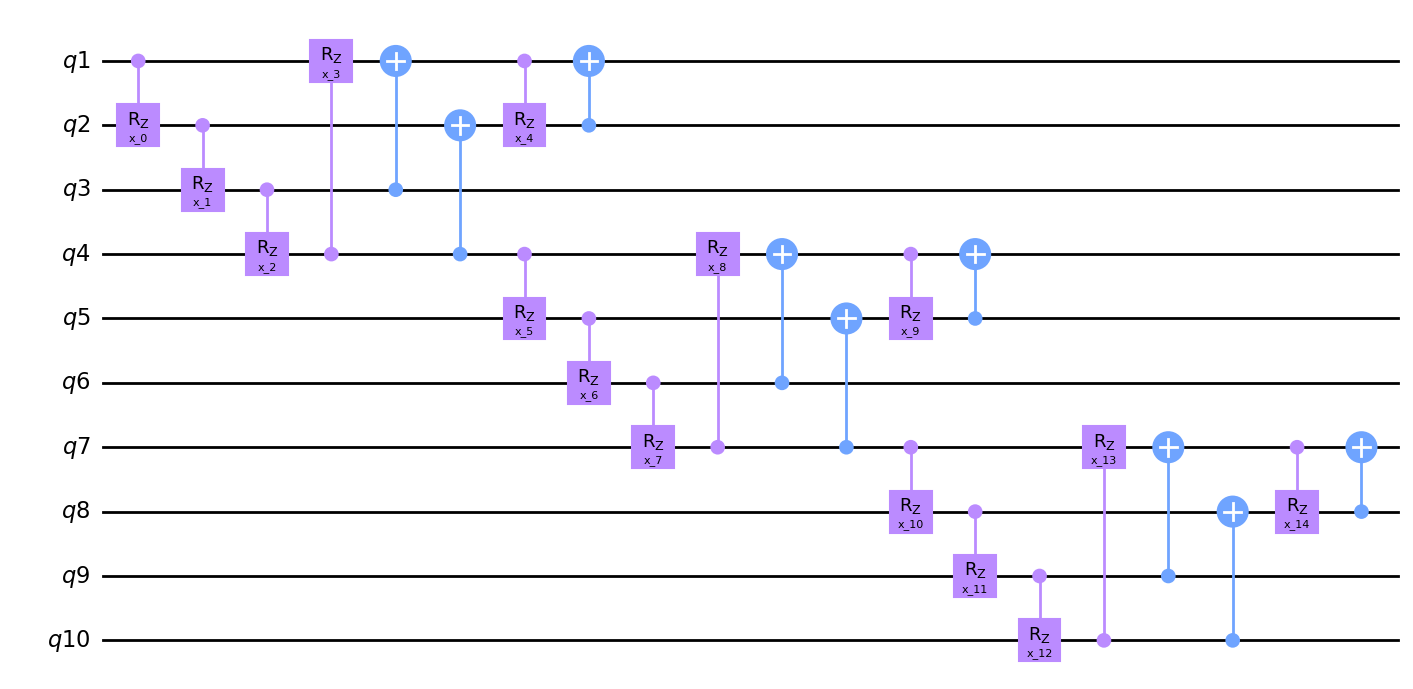

In [201]:
m1 = Qinit(4) + (Qcycle(mapping=u2, share_weights=False) + Qmask("right", mapping=v2)) * 2
hierq = Qinit(10) + Qcycle(1, 3, mapping=m1, boundary="open", share_weights=False)
circuit = get_circuit(hierq)
draw_circuit(circuit)

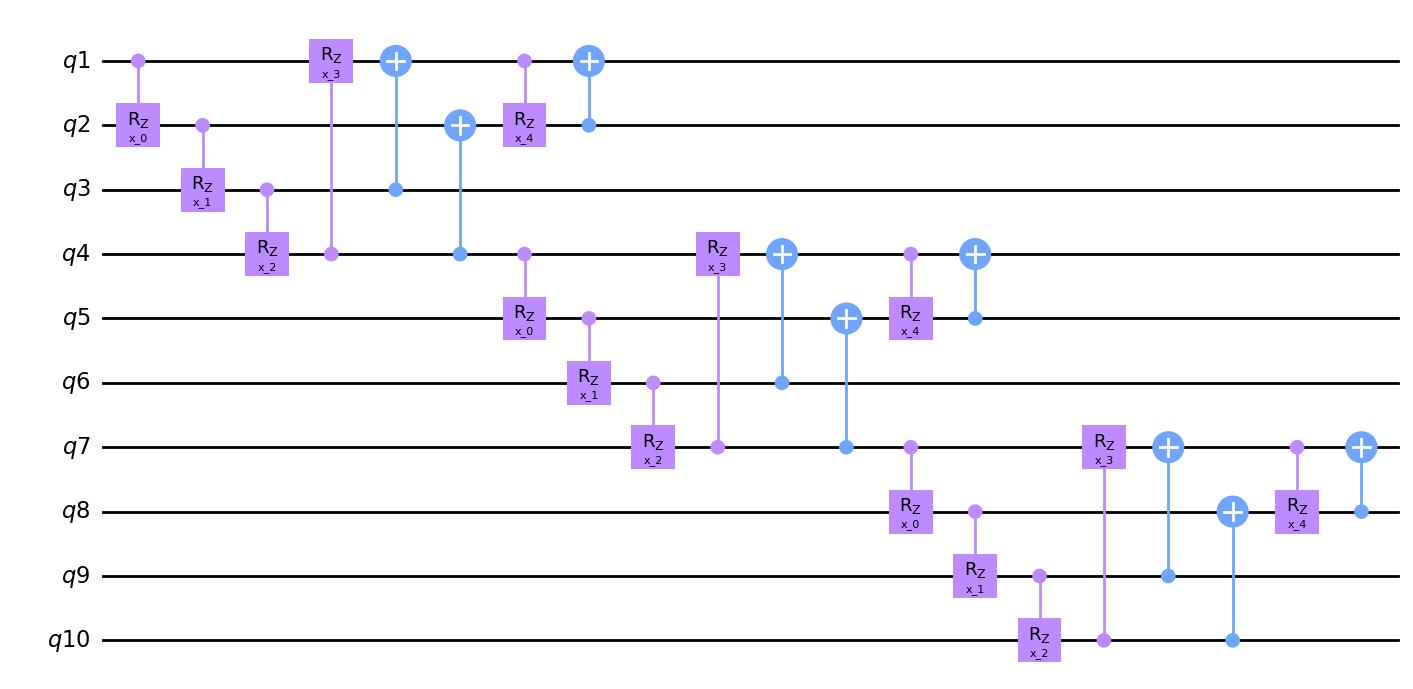

In [202]:
m1 = Qinit(4) + (Qcycle(mapping=u2, share_weights=False) + Qmask("right", mapping=v2)) * 2
hierq = Qinit(10) + Qcycle(1, 3, mapping=m1, boundary="open", share_weights=True)
circuit = get_circuit(hierq)
draw_circuit(circuit)

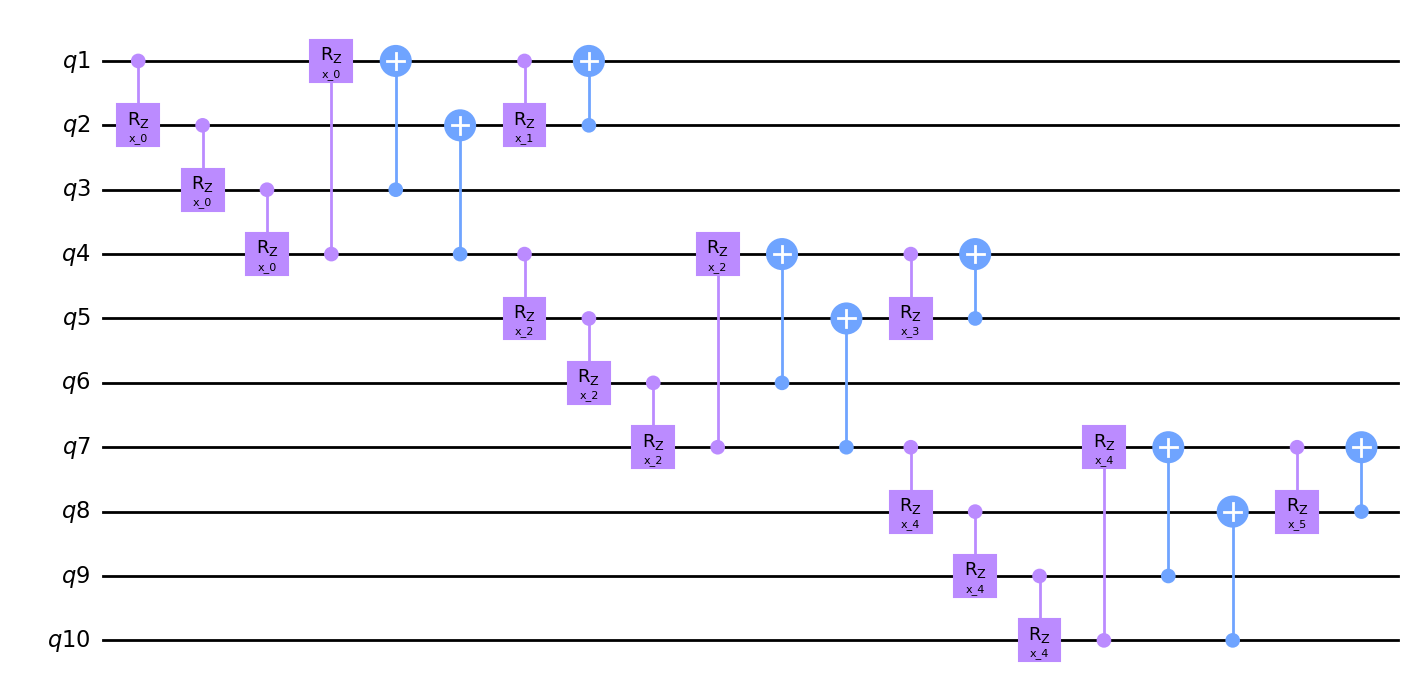

In [203]:
m1 = Qinit(4) + (Qcycle(mapping=u2, share_weights=True) + Qmask("right", mapping=v2)) * 2
hierq = Qinit(10) + Qcycle(1, 3, mapping=m1, boundary="open", share_weights=False)
circuit = get_circuit(hierq)
draw_circuit(circuit)

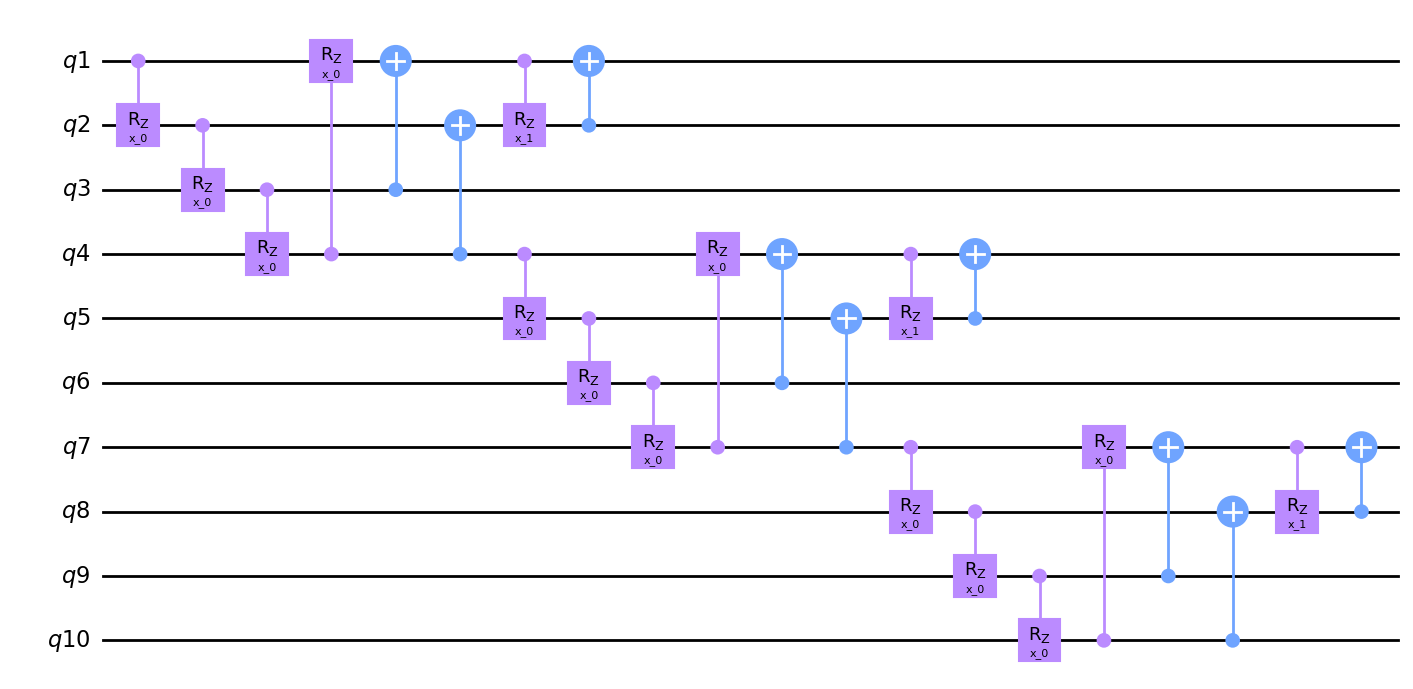

In [204]:
m1 = Qinit(4) + (Qcycle(mapping=u2, share_weights=True) + Qmask("right", mapping=v2)) * 2
hierq = Qinit(10) + Qcycle(1, 3, mapping=m1, boundary="open", share_weights=True)
circuit = get_circuit(hierq)
draw_circuit(circuit)

### Specifying rotational angles

In [205]:
m1 = Qinit(4) + (Qcycle(mapping=u2, share_weights=True) + Qmask("right", mapping=v2)) * 2
hierq = Qinit(10) + Qcycle(1, 3, mapping=m1, boundary="open", share_weights=True)
hierq.set_symbols(np.random.uniform(0, 2 * np.pi, hierq.n_symbols))
list(hierq.get_symbols())

[1.2941283122956846, 3.895383368532065]

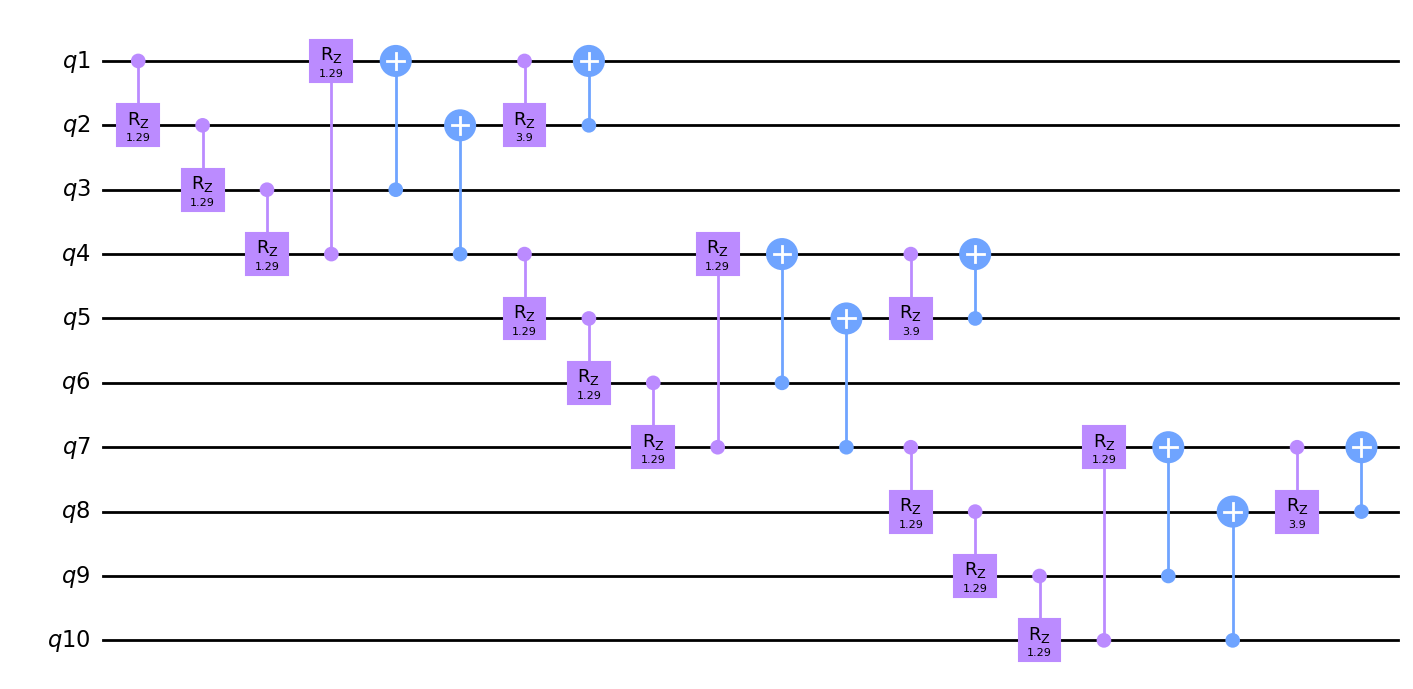

In [206]:
circuit = get_circuit(hierq)
draw_circuit(circuit)

### Symbols as a function

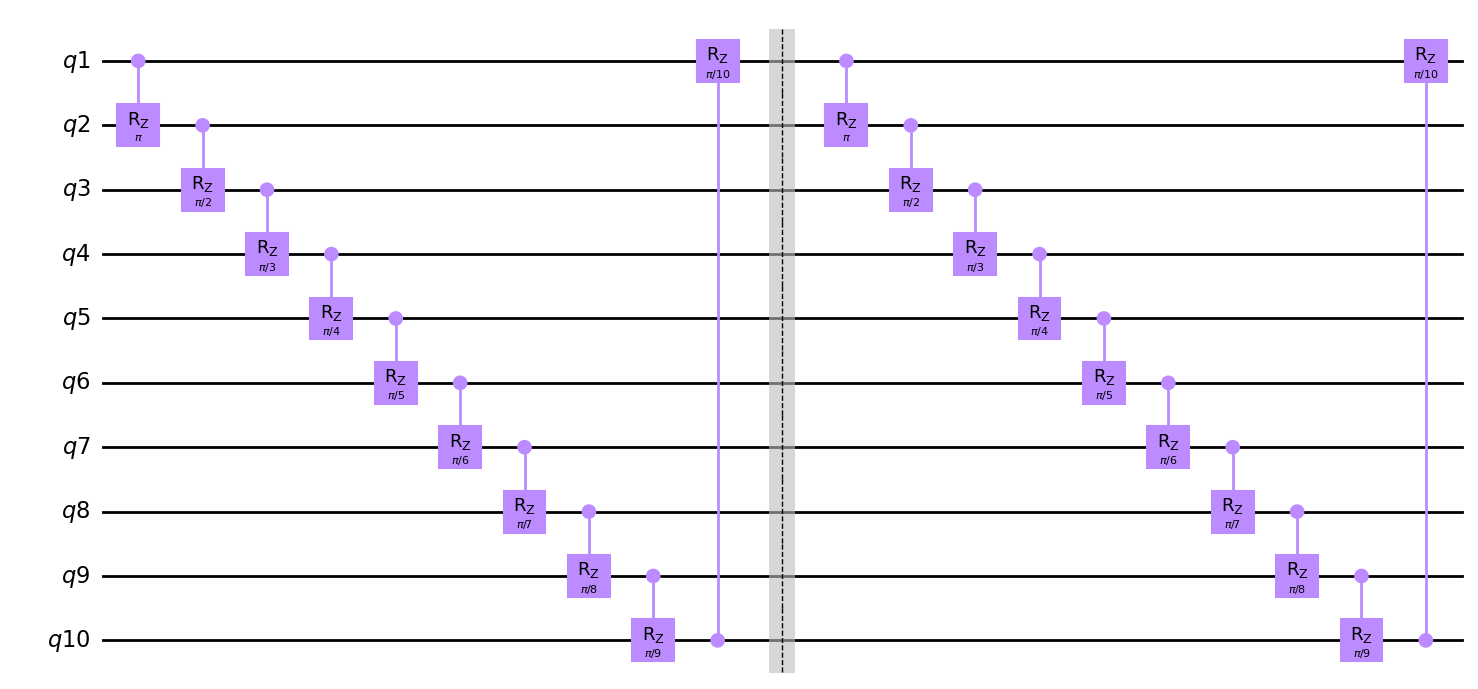

In [207]:
nq = 10
motif = Qcycle
# ne is the edge number, i.e. the first edge corresponds to the first unitary in a layer
# ns is the symbol number which you'll use for unitaries with multiple symbols
symbol_fn = lambda x, ns, ne: np.pi / ne
hierq = Qinit(nq) + motif(mapping=u2, share_weights=False, symbol_fn=symbol_fn) * 2
circuit = get_circuit(hierq)
draw_circuit(circuit)

## Masking

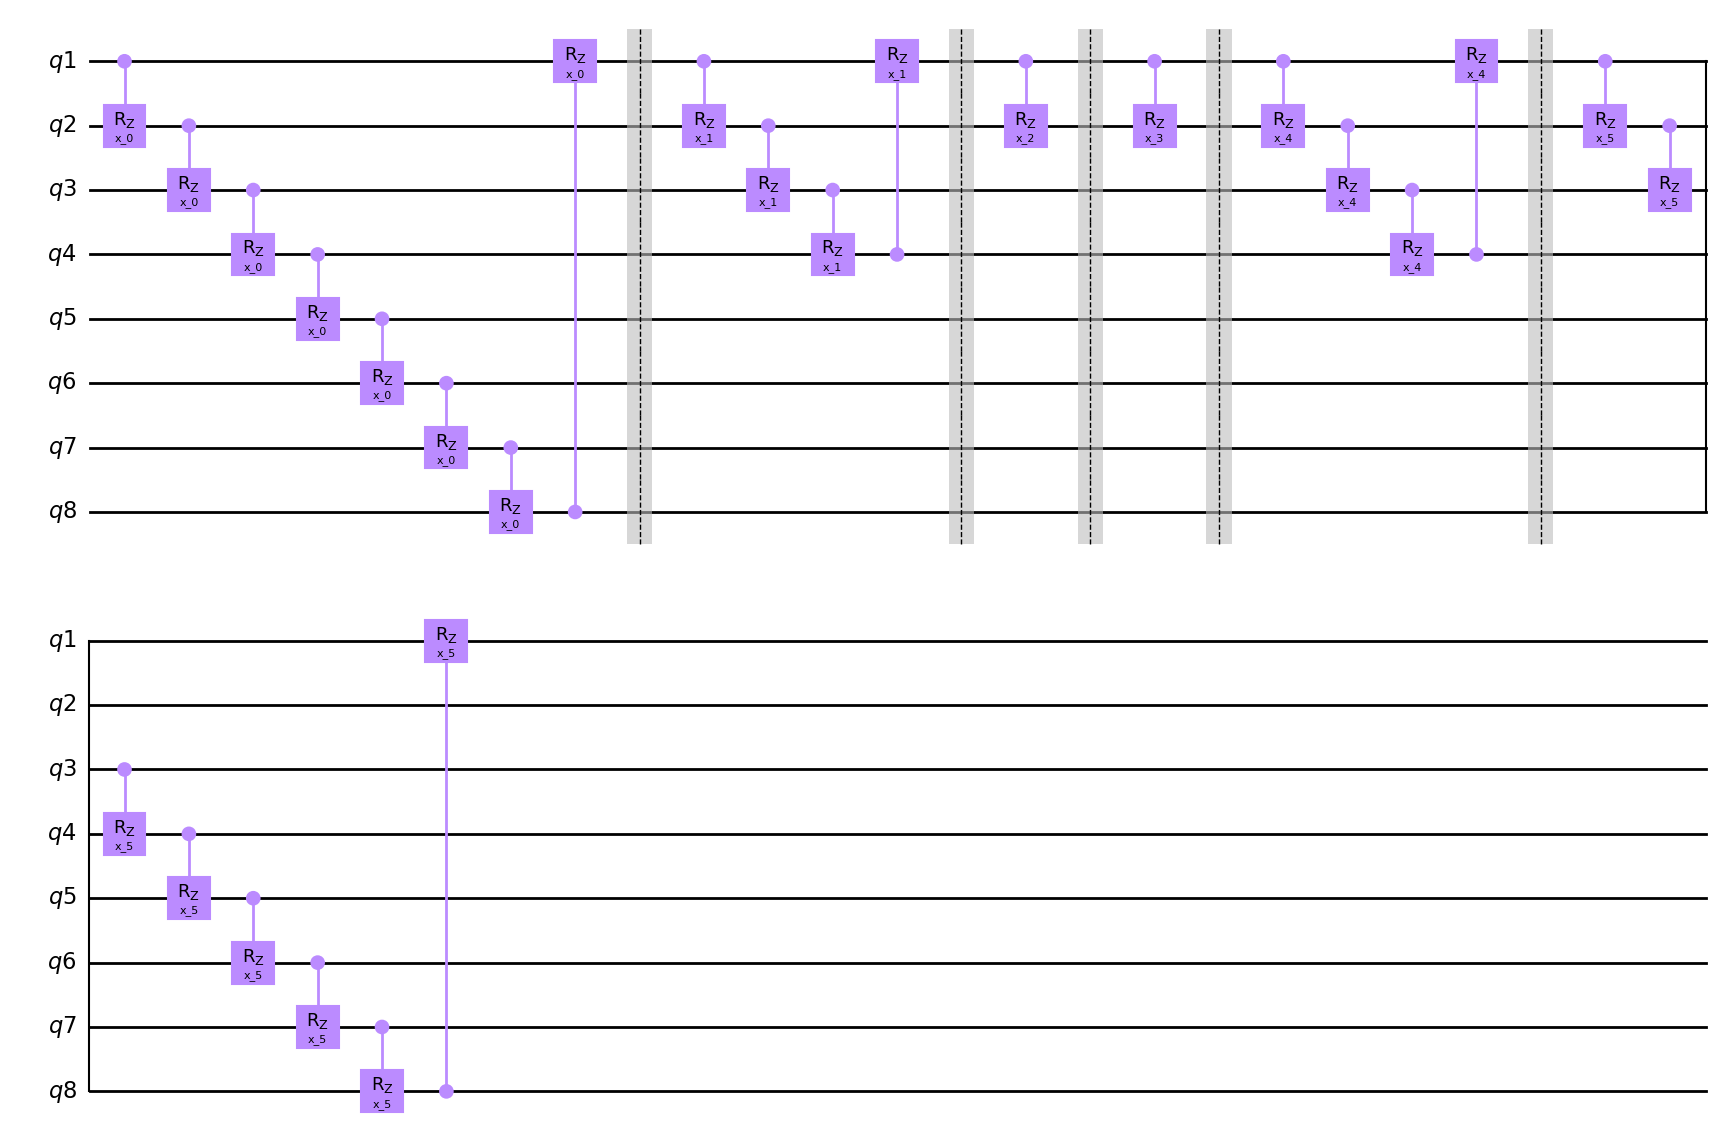

In [208]:
hierq = Qinit(8) + (Qcycle(1, 1, 0, mapping=u2) + Qmask("*!"))*3 + (Qunmask("previous") + Qcycle(1, 1, 0, mapping=u2))*3
circuit = get_circuit(hierq)
draw_circuit(circuit)

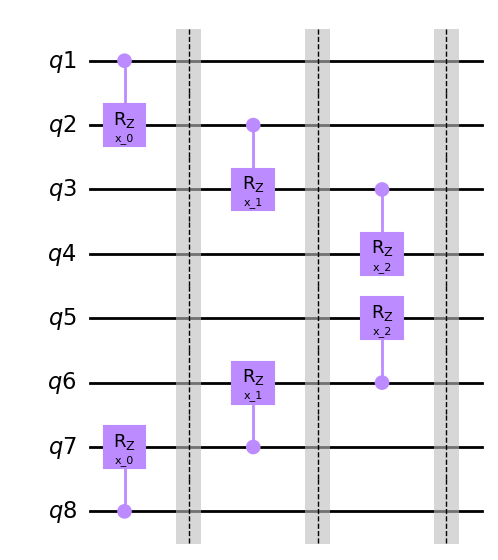

In [209]:
# The global pattern specifies the outside gets masked. 
# The merge between specifies that the masked qubits connect to the outside ones
hierq = Qinit(8) + Qmask(global_pattern="1**1", merge_between="1*1", mapping=u2)*4
circuit = get_circuit(hierq)
draw_circuit(circuit)

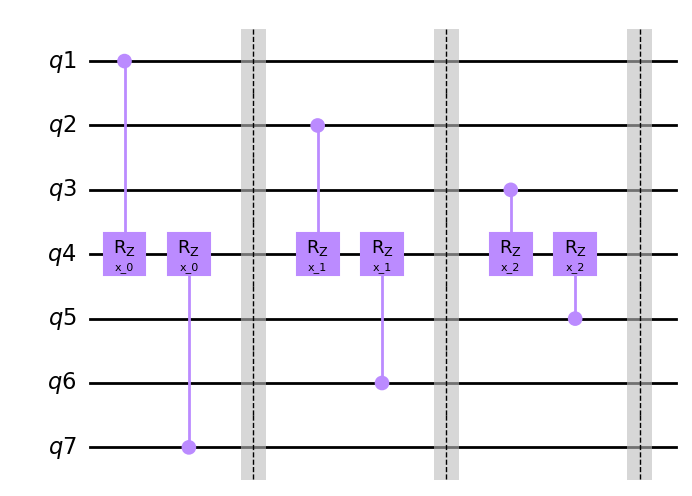

In [210]:
# The global pattern specifies the outside gets masked. 
# The merge between specifies that the masked qubits connect to the inside ones
hierq = Qinit(7) + Qmask(global_pattern="1**1", merge_between="*1*", mapping=u2)*4
circuit = get_circuit(hierq)
draw_circuit(circuit)

## Pivots

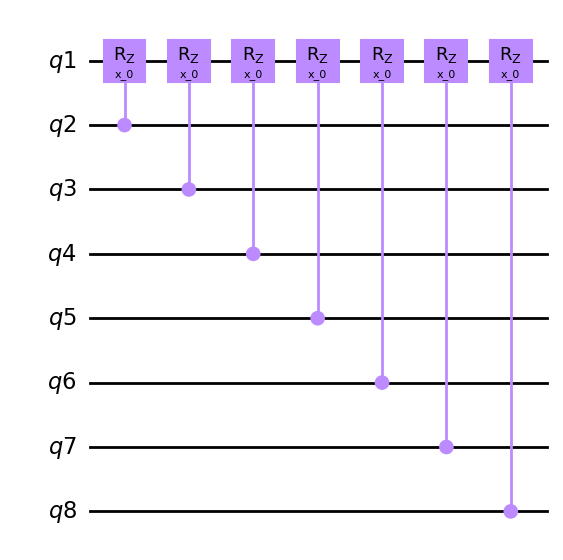

In [211]:
hierq = Qinit(N) + Qpivot(
    global_pattern="1*",
    merge_within="*1",
    merge_between=None,
    strides=[1, 1, 0],
    steps=[1, 1, 1],
    offsets=[0, 0, 0],
    boundaries=["open", "open", "periodic"],
    mapping=u2)
circuit = get_circuit(hierq)
draw_circuit(circuit)

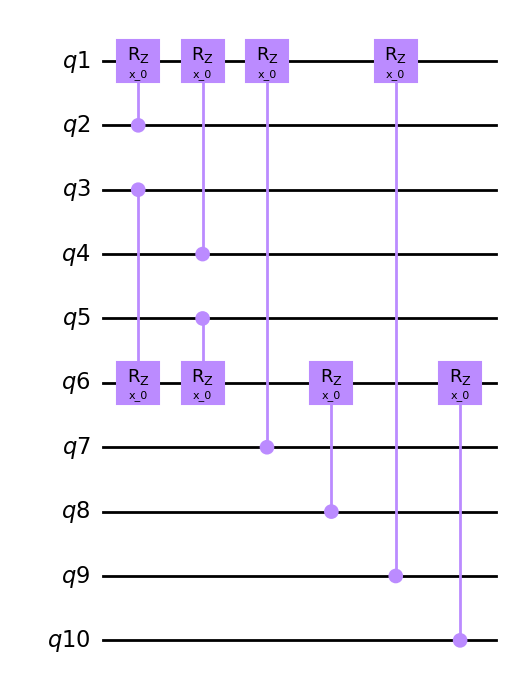

In [212]:
hierq = Qinit(10) + Qpivot(
    global_pattern="1*1*",
    merge_within="*1",
    merge_between=None,
    strides=[1, 1, 0],
    steps=[1, 1, 1],
    offsets=[0, 0, 0],
    boundaries=["open", "open", "periodic"],
    mapping=u2)
circuit = get_circuit(hierq)
draw_circuit(circuit)

## Specifying unitaries

In [213]:
if backend == "qiskit":
    from qiskit.circuit import QuantumRegister
    def anz1(bits, symbols=None, circuit=None, **kwargs):
        
        # Assume bits are strings and in the correct QASM format
        q0, q1 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1])
        circuit.crz(symbols[0], q0, q1)
        circuit.x(q0)
        circuit.crx(symbols[1], q0, q1)

        return circuit

    def anz2(bits, symbols=None, circuit=None, **kwargs):
        # Assume bits are strings and in the correct QASM format
        q0, q1 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1])
        circuit.rz(symbols[0], q1)
        circuit.cnot(q1, q0)
        circuit.rz(symbols[1], q0)
        circuit.ry(symbols[2], q1)
        circuit.cnot(q0, q1)
        circuit.ry(symbols[3], q1)
        circuit.cnot(q1, q0)
        circuit.rz(symbols[1], q0)
        return circuit

elif backend == "cirq":
    import cirq
    # Masking circuit
    def anz1(bits, symbols=None, circuit=None):
        q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
        circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
        circuit += cirq.X(q0)
        circuit += cirq.rx(symbols[1]).on(q1).controlled_by(q0)

        return circuit

    # Cycle circuit
    def anz2(bits, symbols=None, circuit=None):
        q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
        circuit += cirq.rz(symbols[0]).on(q1)
        circuit += cirq.CNOT(q1, q0)
        circuit += cirq.rz(symbols[1]).on(q0)
        circuit += cirq.ry(symbols[2]).on(q1)
        circuit += cirq.CNOT(q0, q1)
        circuit += cirq.ry(symbols[3]).on(q1)
        circuit += cirq.CNOT(q1, q0)
        circuit += cirq.rz(symbols[4]).on(q0)
        return circuit

elif backend == "pennylane":
    # Masking circuit
    def anz1(bits, symbols=None):
        qml.CRZ(symbols[0], wires=[bits[0], bits[1]])
        qml.PauliX(wires=bits[0])
        qml.CRX(symbols[1], wires=[bits[0], bits[1]])

    # Cycle circuit
    def anz2(bits, symbols=None):
        qml.RZ(symbols[0], wires=bits[1])
        qml.CNOT(wires=[bits[1], bits[0]])
        qml.RZ(symbols[1], wires=bits[0])
        qml.RY(symbols[2], wires=bits[1])
        qml.CNOT(wires=[bits[0], bits[1]])
        qml.RY(symbols[3], wires=bits[1])
        qml.CNOT(wires=[bits[1], bits[0]])
        qml.RZ(symbols[4], wires=bits[0])


u = Qunitary(anz2, 5, 2)
v = Qunitary(anz1, 2, 2)

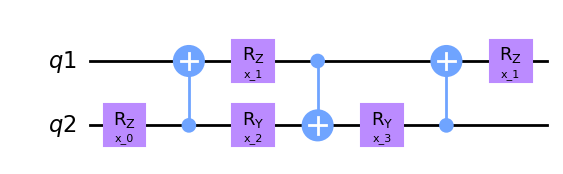

In [214]:
ansatz_1 = Qinit(2) + Qcycle(mapping=u)
circuit = get_circuit(ansatz_1)
draw_circuit(circuit)

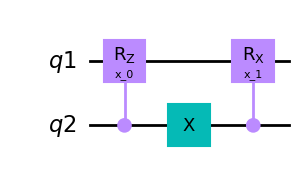

In [215]:
ansatz_2 = Qinit(2) + Qmask("right", mapping=v)
circuit = get_circuit(ansatz_2)
draw_circuit(circuit)

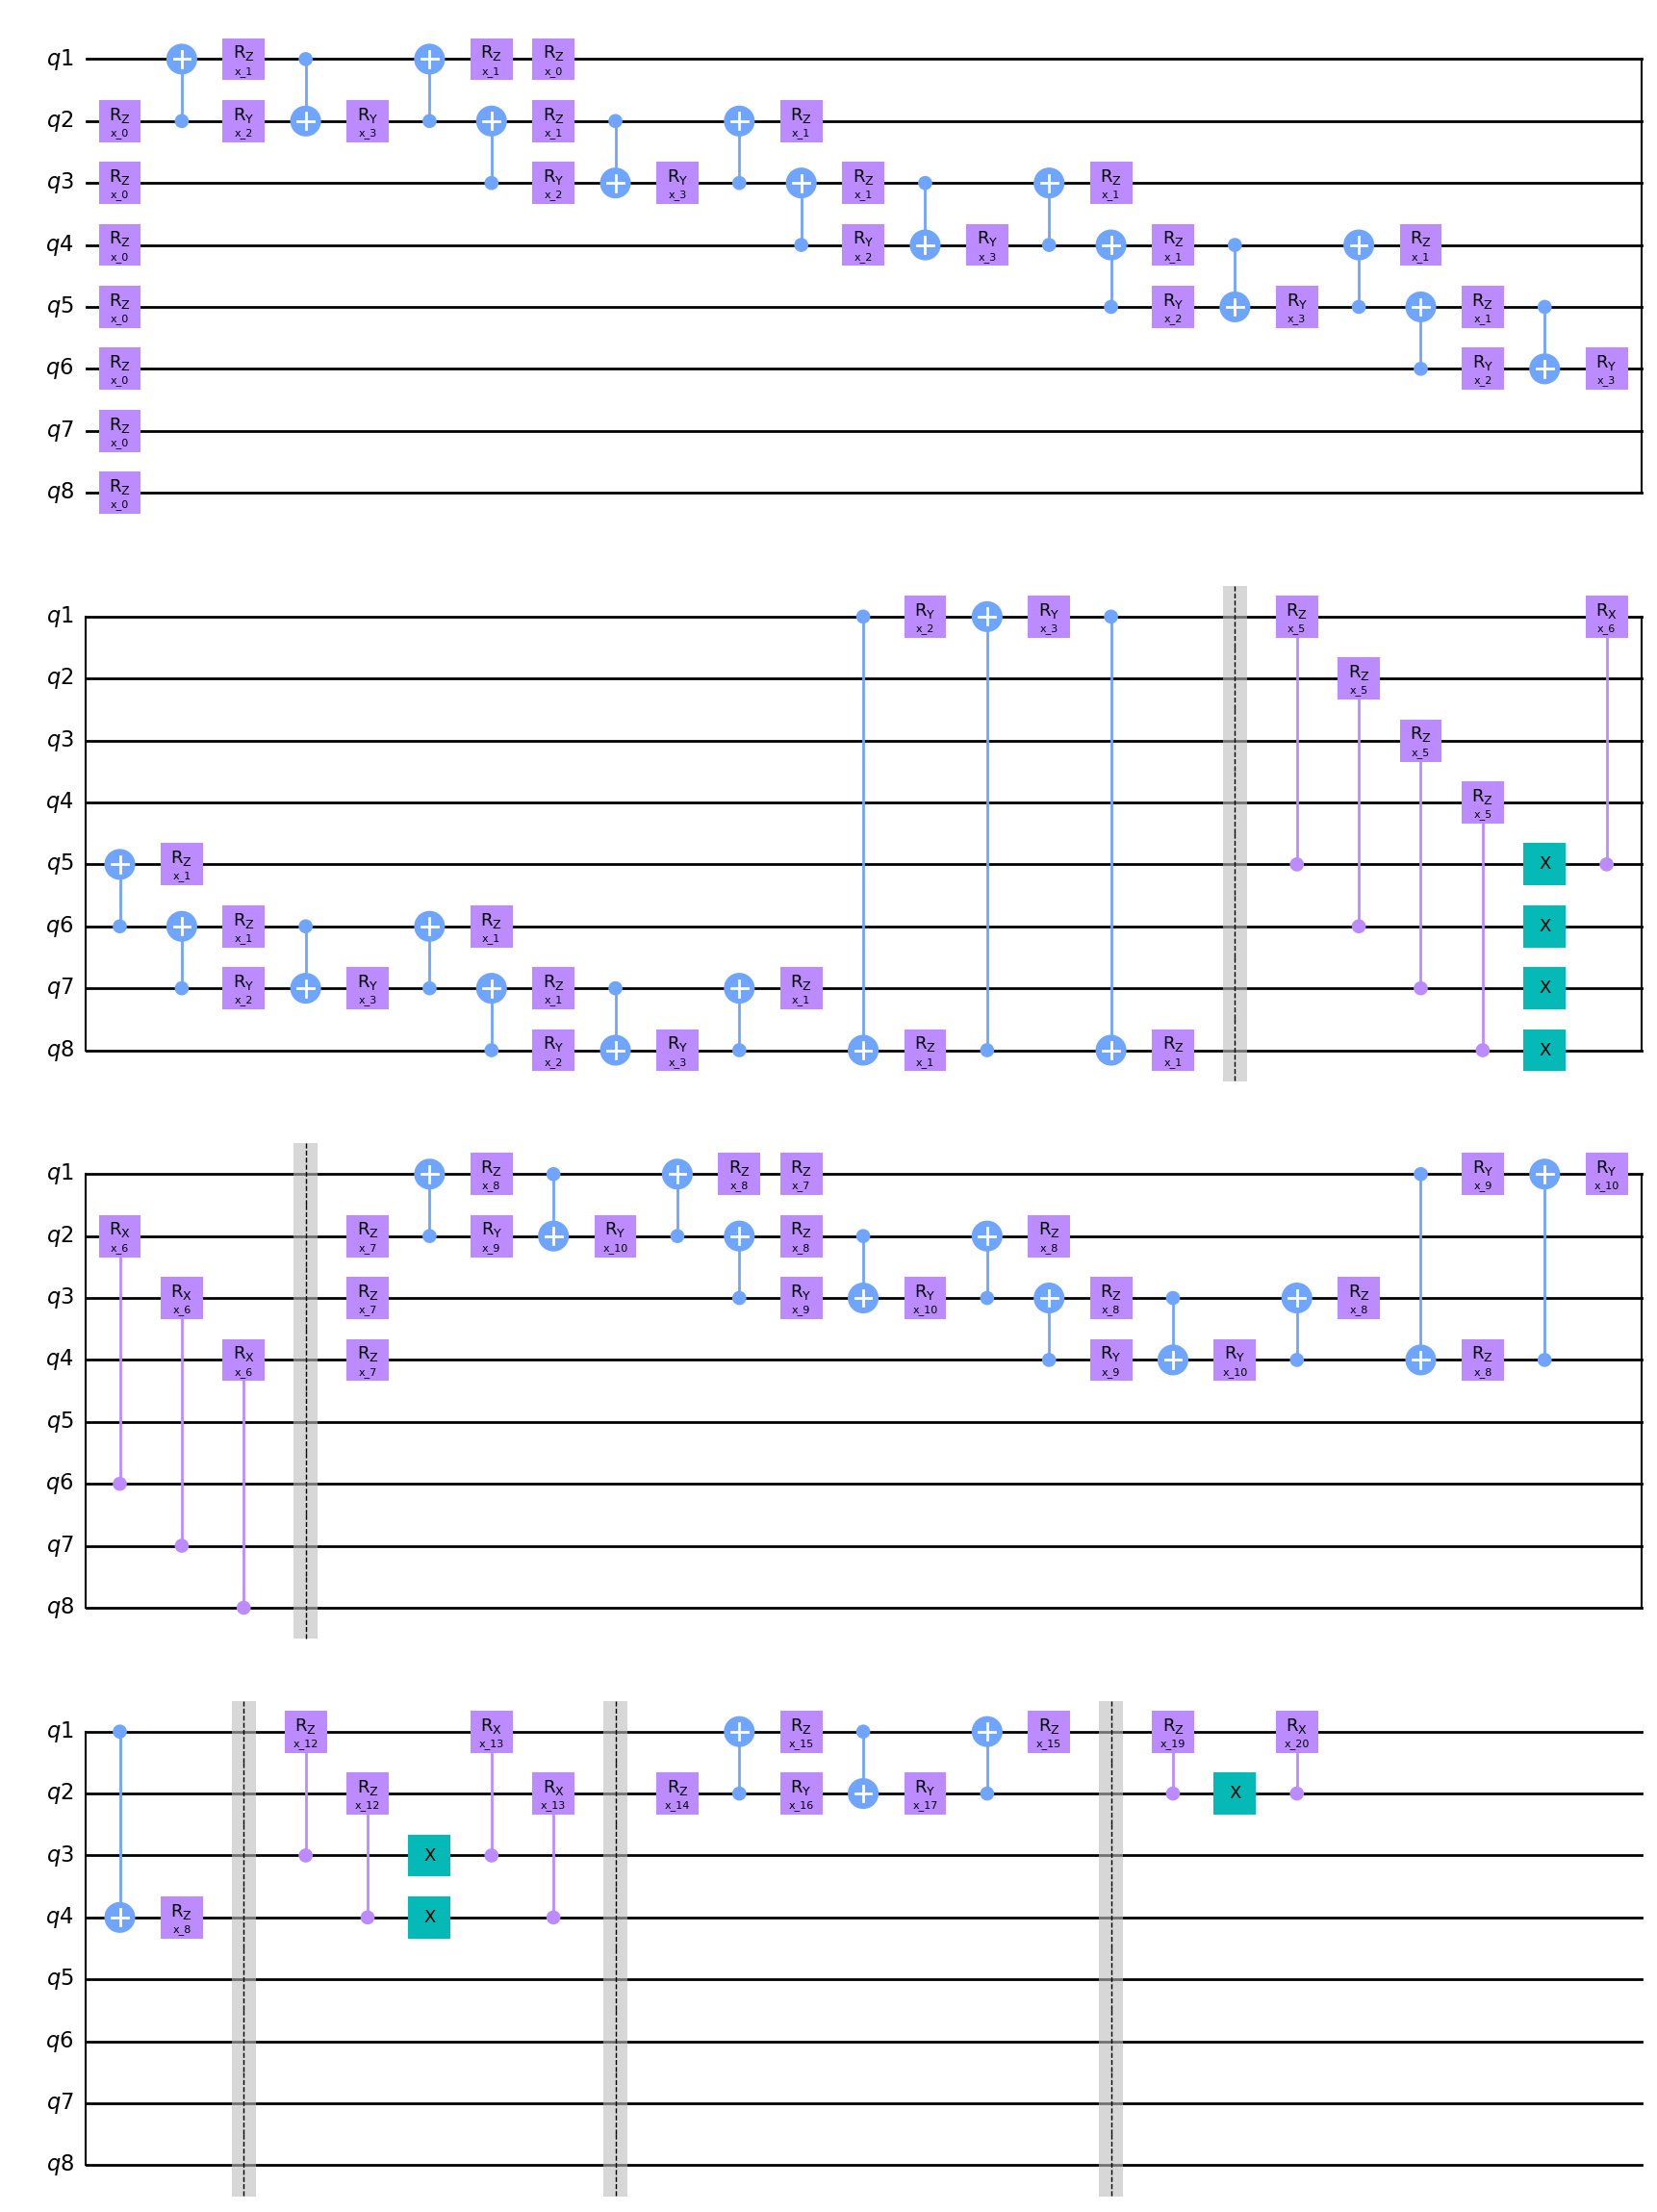

In [216]:
hierq = Qinit(8) + (Qcycle(1, mapping=u) + Qmask(global_pattern="*!", mapping=v)) * 3
circuit = get_circuit(hierq)
draw_circuit(circuit)